# Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow, 2nd Edition

## by Aurelien Geron

### Notes by Melis Tekant

## Chapter 3: Classification

In [22]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.datasets import fetch_openml
from sklearn. linear_model import SGDClassifier

In this chapter, classification methods will be discussed, using the MNIST dataset. 

In [5]:
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
# Separating data and target
X,y = mnist['data'],mnist['target']

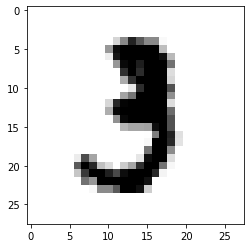

In [15]:
# Looking at a random image
digit = X[10]
digit_image = digit.reshape(28,28)
plt.imshow(digit_image,cmap=mpl.cm.binary);

In [19]:
# Looking at what the label is for this image
y.astype('int')[10]

3

In [23]:
# Training and test sets
y = y.astype('int')
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [37]:
# Building a binary classifier for the number 5

# Setting results to True/False for 5/not-5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#Stochastic Gradient Descent Classifier

sgd = SGDClassifier(random_state = 42)
sgd.fit(X_train,y_train_5)
sgd.predict([digit])

array([False])

array([ True])

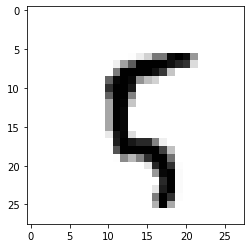

In [38]:
plt.imshow(X[100].reshape(28,28),cmap=mpl.cm.binary)
sgd.predict([X[100]])

In [39]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd,X_train,y_train_5, cv=3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [40]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd,X_train,y_train_5,cv=3)

In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Since the percentage of correct idenfitications may be misleading, especially in the case that there are a lot more in one class than the other, the validation score metric does not give an accurate sense of the goodness of fit of the model. We can use the confusion matrix to get more info (shown above), but if we need more compact, single value results, we turn to the following: 

1. Precision, or the accuracy of positive predictions: TP/(TP+FP)
2. Recall = Sensitivity = True positive rate = TP/(TP+FN)

where TP = true positive, FP = false positive, and FN = false negative.

Combining precision and recall scores, we can define $F_1$ score, the harmonic mean of precision and recall scores. 

$$F_1 = \frac{2}{\frac{1}{precision} +\frac{1}{recall}} $$

Increasing/decreasing precision reduces/increases recall: precision/recall tradeoff. The ideal point for these values is dependent on the desired application.

In [44]:
from sklearn.metrics import precision_score, recall_score,f1_score

print('Precision Score: ', str(precision_score(y_train_5,y_train_pred)))
print('Recall Score: ', str(recall_score(y_train_5,y_train_pred)))
print('F1 Score: ', str(f1_score(y_train_5,y_train_pred)))

Precision Score:  0.8370879772350012
Recall Score:  0.6511713705958311
F1 Score:  0.7325171197343846


In [46]:
# Now let's visualize the precision-recall trade-off:

y_scores = cross_val_predict(sgd,X_train,y_train_5, cv=3, method = 'decision_function')

In [67]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

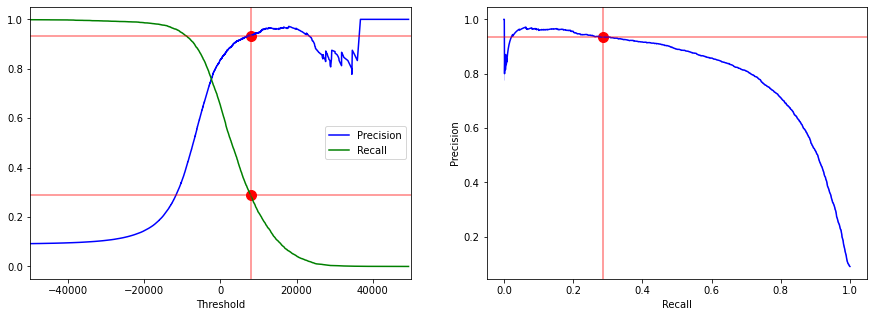

In [79]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(x = thresholds,y = precisions[:-1],color='b',label="Precision")
sns.lineplot(x = thresholds, y = recalls[:-1], color= 'g', label = "Recall")
plt.legend()
plt.xlim([-50000,50000])
plt.xlabel('Threshold')

#Let's choose 8000 as a threshold value
thres = 8000
thresh2 = (thresholds - thres)**2
minval = min(thresh2)
closest_idx = np.where(thresh2 == minval)

plt.axvline(thres,color = 'r', alpha = 0.5);
plt.axhline(precisions[closest_idx],color ='r', alpha = 0.5)
plt.axhline(recalls[closest_idx], color = 'r', alpha = 0.5)
plt.scatter(thres,precisions[closest_idx],color = 'r', s= 100)
plt.scatter(thres,recalls[closest_idx],color = 'r', s= 100)

plt.subplot(1,2,2)
sns.lineplot(x = recalls, y = precisions, color = 'b')
plt.axhline(precisions[closest_idx],color = 'r', alpha = 0.5)
plt.axvline(recalls[closest_idx], color = 'r', alpha =0.5)
plt.scatter(recalls[closest_idx],precisions[closest_idx],color = 'r', s=100)
plt.xlabel('Recall')
plt.ylabel('Precision');

The receiver operating characteristic (ROC) curve: true positive rate (recall) vs. false positive rate (FPR). 

FPR = 1 - true negative rate (specificity). 

Thus, ROC is the plot of sensitivity vs. 1 - specificity. 

The larger the area under the ROC curve, the better the classifier is. A random classifier gives a diagonal line (0.5 area), and a perfect classifier hugs the top left corner perfectly (1 area).  

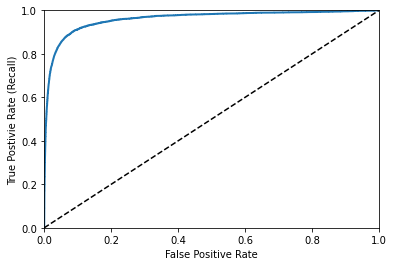

In [89]:
from sklearn.metrics import roc_curve

fpr, tpr, thresh = roc_curve(y_train_5,y_scores)

plt.plot(fpr,tpr,linewidth=2)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Postivie Rate (Recall)')
plt.xlim(0,1)
plt.ylim(0,1);

In [90]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

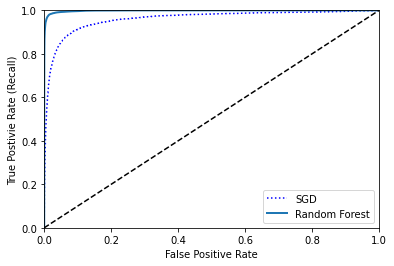

In [91]:
# Compare SGDClassifier to a RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = 'predict_proba')
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr,tpr,'b:',label='SGD')
plt.plot(fpr_forest,tpr_forest,linewidth=2,label='Random Forest')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Postivie Rate (Recall)')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1);

In [92]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

Random Forest classifier shows significant improvement over the Stochastic Gradient Descent classifier in terms of the ROC area under curve (AUC). 

- Choose to use PR curve (over ROC) when the positive class is rare or when false positives are more detrimental than false negatives. 

Now let's extend our analysis to not just binary classifiers, but multiclass classifiers (multinomial classifiers). Some altogrithms can handle multiple classes (e.g. Random Forest, naive Bayes), and others can only do binary classification (e.g. Support Vector Machine or Linear), but these can be used to perform multiclass classification by using multiple classifiers. 

For example for the digit classifier, can make a binary classifier for each digit, get decision score, and select the one with the highest score. This method is called one-versus-all (OvA) strategy. 

Another option is to train binary classifiers on pairs of digits, then choose the value that wins most against other digits. This would necessitate training N choose 2 classifiers, but can train just the set that has the two classes (for algorithms that don't scale well with training set size, this may be prefered, e.g. Support Vector Machines). This is called one-versus-one(OvO) strategy. 

Scikit-Learn uses OvA automatically when binary classification is used for a multi-class classification tast, except for SVM, for which it uses OvO. 

In [94]:
sgd.fit(X_train,y_train)
sgd.predict([digit])

array([3])

Here, sklearn trained 10 binary classifiers and compared their decision scores, selecting the highest one. 

You can force sklearn to use a different strategy manually.

In [95]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([digit])

array([3])

In [96]:
forest_clf.fit(X_train,y_train)
forest_clf.predict([digit])

array([3])

In [97]:
forest_clf.predict_proba([digit])

array([[0.  , 0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ]])

Note: This image was very very clearly a 3, and the closest other option was 5. It would be interesting to see which digits are usually closer to one another, and are more difficult to distinguish. 

In [101]:
cross_val_score(sgd,X_train,y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [103]:
# Decent score, but can boost accuracy by simply scaling values.
# Scaling values should basically be done each time. 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

- In a real world application, don't forget to explore data prep options, try out various ML models, and fine-tune hyperparameters using GridSearchCV to reach the maximum predictive potential.

In [104]:
# Let's look at the confusion matrix.

y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train, cv =3)
confuse = confusion_matrix(y_train, y_train_pred)
confuse 

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

<ipython-input-127-f91513b75be5>:2: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(confuse));


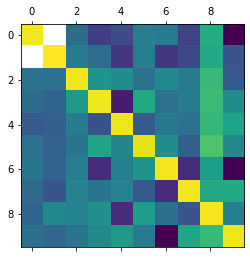

In [127]:
# Using log(value) to bring out the errors more.
plt.matshow(np.log(confuse));

#It will have trouble with 0 values, but we'll ignore that for now.

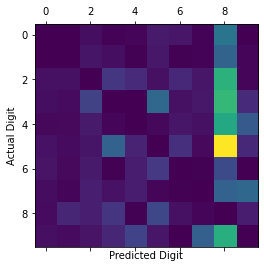

In [109]:
# Normalize each value, and plot just errors in a similar method to above

row_sums = confuse.sum(axis=1,keepdims=True)
norm_confuse = confuse/row_sums
np.fill_diagonal(norm_confuse,0)
plt.matshow(norm_confuse)
plt.xlabel('Predicted Digit')
plt.ylabel('Actual Digit');

Pretty interesting, many digits seem to be classified as 8, especially 5. 
5 and 3 as well as 7 and 9 also get misclassified as one another, which is understandable. Another common misclassification is 4 as 9.

As pointed out in the text, these classifications look at each pixel value, so if digits are written with a rotation or a shift, or stretched out in a certain direction, the classifier fails. For these types of questions, it would be ideal to either preprocess images, or better yet, use methods that do not rely on the analysis of individual pixels. Putting that thought aside, we will look at multilabel classification.

In [110]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

knn = KNeighborsClassifier()
knn.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [111]:
# Remember, our digit is 3
knn.predict([digit])

array([[False,  True]])

The digit is not large, but it is odd so the above answer is correct. This is an example of a multilabel classifier. 

To evaluate a multilabel classifier, one could use the F1 score for each label, and average. Different weights can be given to different labels, if some are more important than others. For example, the weight can be equal to the number of instances of that label (support). In the f1_score function in sklearn, set average = 'weighted' to perform this type of weighing. 

Multiclass classification is a generalization of the multilable classification, where each label can have multiple values, not just binary. 

Let's add some noise on top of the MNIST images and build a model that cleans them.

In [114]:
noise = np.random.randint(0,100,(len(X_train),28*28))
X_train_noisy = X_train + noise
noise1 = np.random.randint(0,100,(len(X_test),28*28))
X_test_noisy = X_test + noise1
y_train_clean = X_train
y_test_clean = X_test

In [118]:
knn.fit(X_train_noisy,y_train_clean)
clean_digit = knn.predict([X_test_noisy[10]])

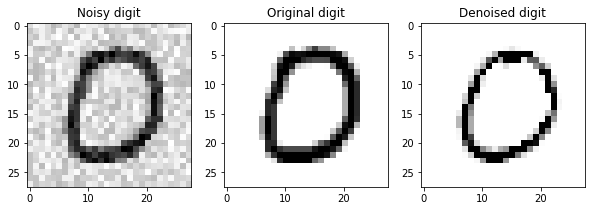

In [126]:
plt.subplots(figsize=(10,30))
plt.subplot(1,3,1)
plt.imshow(X_test_noisy[10].reshape(28,28),cmap=mpl.cm.binary)
plt.title('Noisy digit')
plt.subplot(1,3,2)
plt.imshow(X_test[10].reshape(28,28),cmap=mpl.cm.binary)
plt.title('Original digit')
plt.subplot(1,3,3)
plt.imshow(clean_digit.reshape(28,28),cmap=mpl.cm.binary)
plt.title('Denoised digit');

Note: I'm not thrilled with this example, since the model clearly maps high values to high values, and low values to 0. I could write a script that does just that just as easily, without the need of ML methods, but it's fine as a demonstrative toy example.

Exercises:

4.

The first thing I will do in this question is read the files and separate the header from the body.

In [278]:
import glob, email, email.policy

path  = '/Users/melistekant/Documents/Python Projects/Datasets/SpamAssassin/spam/*'
#def read_spam_ham(path):
df = pd.DataFrame(columns = ['subject','content'])
for filename in glob.glob(path):
    f = open(filename,'rb')
    parser = email.parser.BytesParser(policy=email.policy.default).parse(f)
    body = parser.get_content()
    subject = parser['Subject']
    minidf = pd.DataFrame({'subject': [subject], 'content': [body]})
    df = pd.concat([df,minidf])        
    

KeyError: 'multipart/alternative'